In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [2]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe

df = pd.read_csv("E:\\PROJECTS\\MLWARE\\dataset\\train\\train_faces.csv", dtype = dt)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.16it/s]


<Figure size 432x288 with 0 Axes>

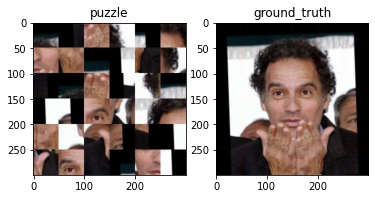

In [3]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("E:\\PROJECTS\\MLWARE\\dataset\\train\\faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("E:\\PROJECTS\\MLWARE\\dataset\\train\\faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

train_img = load_images(train_df)
val_img = load_images(val_df)




In [4]:

print(train_img.shape)
print(val_img.shape)
#2400 puzzles, 36 pieces, each piece is a 50x50x3 image

(80, 36, 50, 50, 3)
(19, 36, 50, 50, 3)


In [5]:
train_img

array([[[[[219, 158, 137],
          [218, 160, 138],
          [218, 160, 138],
          ...,
          [196, 124, 110],
          [234, 130, 129],
          [208, 140, 131]],

         [[218, 157, 136],
          [219, 158, 137],
          [219, 158, 137],
          ...,
          [203, 131, 117],
          [235, 131, 130],
          [209, 141, 132]],

         [[218, 156, 135],
          [219, 157, 136],
          [220, 158, 137],
          ...,
          [214, 141, 126],
          [238, 134, 133],
          [210, 142, 133]],

         ...,

         [[177, 105,  91],
          [179, 107,  93],
          [181, 109,  95],
          ...,
          [210, 105, 102],
          [223, 106, 115],
          [193, 111, 113]],

         [[188, 101,  92],
          [188, 101,  92],
          [190, 103,  94],
          ...,
          [223, 125, 124],
          [183, 151, 156],
          [176, 145, 150]],

         [[166, 114,  93],
          [167, 115,  94],
          [168, 115,  97],
         

In [6]:
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

train_labels = load_labels(train_df)
val_labels = load_labels(val_df)
print(train_labels.shape)
print(val_labels.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1058.38it/s]

(80, 36, 36)
(19, 36, 36)


In [7]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow import keras

In [8]:
inp = tf.keras.layers.Input(shape=(36,50,50,3))

In [9]:
#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(5, (5,5), strides=5)
conv2 = tf.keras.layers.Conv2D(5, (5,5), strides=5)
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = conv2(x)
    x = flat(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability


model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy'])

tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch1 = tf.keras.layers.BatchNormalization()
max_pool1 = tf.keras.layers.MaxPooling2D()
conv2 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch2 = tf.keras.layers.BatchNormalization()
max_pool2 = tf.keras.layers.MaxPooling2D()
conv3 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch3 = tf.keras.layers.BatchNormalization()
d3 = tf.keras.layers.Dropout(0.4)
flat = tf.keras.layers.Flatten()
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i])
    x = batch1(x)
    x = max_pool1(x)
    x = conv2(x)
    x = batch2(x)
    x = max_pool2(x)
    x = conv3(x)
    x = batch3(x)
    x = d3(x)
    x = flat(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [11]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [13]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=10)

Epoch 1/10
5/5 [==============================] - 29s 4s/step - loss: 5.0435 - val_loss: 7.0711
Epoch 2/10
2/5 [===========>..................] - ETA: 10s - loss: 4.0851

KeyboardInterrupt: 

In [11]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=10)
model.summary()


Epoch 1/10
5/5 [==============================] - 0s 44ms/step - loss: 3.2039 - accuracy: 0.1590 - val_loss: 3.4400 - val_accuracy: 0.1170
Epoch 2/10
5/5 [==============================] - 0s 47ms/step - loss: 3.2014 - accuracy: 0.1604 - val_loss: 3.4480 - val_accuracy: 0.1126
Epoch 3/10
5/5 [==============================] - 0s 45ms/step - loss: 3.1983 - accuracy: 0.1590 - val_loss: 3.4272 - val_accuracy: 0.1111
Epoch 4/10
5/5 [==============================] - 0s 49ms/step - loss: 3.1935 - accuracy: 0.1628 - val_loss: 3.4325 - val_accuracy: 0.1155
Epoch 5/10
5/5 [==============================] - 0s 52ms/step - loss: 3.1894 - accuracy: 0.1604 - val_loss: 3.4289 - val_accuracy: 0.1272
Epoch 6/10
5/5 [==============================] - 0s 47ms/step - loss: 3.1860 - accuracy: 0.1601 - val_loss: 3.4259 - val_accuracy: 0.1155
Epoch 7/10
5/5 [==============================] - 0s 46ms/step - loss: 3.1838 - accuracy: 0.1635 - val_loss: 3.4206 - val_accuracy: 0.1155
Epoch 8/10
5/5 [===========

 tf.__operators__.getitem_21 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_22 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_23 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_24 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpL

                                                                 0]',                             
                                                                  'tf.__operators__.getitem_20[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_21[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_22[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_23[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_24[0][
          

                                                                  'conv2d_1[12][0]',              
                                                                  'conv2d_1[13][0]',              
                                                                  'conv2d_1[14][0]',              
                                                                  'conv2d_1[15][0]',              
                                                                  'conv2d_1[16][0]',              
                                                                  'conv2d_1[17][0]',              
                                                                  'conv2d_1[18][0]',              
                                                                  'conv2d_1[19][0]',              
                                                                  'conv2d_1[20][0]',              
                                                                  'conv2d_1[21][0]',              
          

                                                                  'dense[21][0]',                 
                                                                  'dense[22][0]',                 
                                                                  'dense[23][0]',                 
                                                                  'dense[24][0]',                 
                                                                  'dense[25][0]',                 
                                                                  'dense[26][0]',                 
                                                                  'dense[27][0]',                 
                                                                  'dense[28][0]',                 
                                                                  'dense[29][0]',                 
                                                                  'dense[30][0]',                 
          

In [ ]:
import os

image_dir = "faces"  # directory containing images

# get a list of file names in the directory
file_names = os.listdir(image_dir)

# filter the list to include only image file names
image_names = [name for name in file_names if name.lower().endswith((".jpg", ".jpeg", ".png"))]


In [ ]:
def loadtest_images(image_paths):
    ret = []
    for img_path in tqdm(image_paths):
        pieces = []
        img_name = os.path.basename(img_path)
        img = Image.open("faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [ ]:
q=loadtest_images(image_names)

In [ ]:
pred = model.predict(q)
pred = np.argmax(pred, axis=-1)
print(pred.shape)
print(pred)

In [ ]:
pred.shape

In [ ]:
len(image_names)
import pandas as pd

# Example list of image names

# Create a DataFrame with a single "image" column
image1_df = pd.DataFrame({"image": image_names})

# Print the resulting DataFrame
print(image1_df)


In [ ]:
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(image1_df["image"])
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [ ]:
out

In [ ]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [ ]:
submission = prediction_to_submission(out)

In [ ]:
submission

In [ ]:
import pandas as pd

# assume that 'out' is a variable that contains the prediction output
submission = prediction_to_submission(out) 

file_path = "facesub4.csv"  # replace with the path and file name where you want to save the CSV file

# convert the DataFrame to a CSV format
csv_content = submission.to_csv(index=False)

# write the CSV content to a file
with open(file_path, "w") as f:
    f.write(csv_content)

print("CSV file downloaded successfully!")


In [ ]:
import pandas as pd

# Read in CSV file
df = pd.read_csv("facesub4.csv")

# Drop rows with missing values
df = df.dropna()

# Print resulting DataFrame
print(df)

In [ ]:
df.to_csv("face_final_submssion3.csv", index=False)

# Print confirmation message
print("CSV file saved successfully.")